<a href="https://colab.research.google.com/github/farenga/meshGNN/blob/main/runtime_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/networkx/networkx-metis.git
!cd networkx-metis; python setup.py install

fatal: destination path 'networkx-metis' already exists and is not an empty directory.
running install
running bdist_egg
running egg_info
writing networkx_metis.egg-info/PKG-INFO
writing dependency_links to networkx_metis.egg-info/dependency_links.txt
writing requirements to networkx_metis.egg-info/requires.txt
writing top-level names to networkx_metis.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE.txt'
adding license file 'NOTICE'
writing manifest file 'networkx_metis.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running build_clib
building 'gklib' library
building 'metis' library
running install_lib
running build_py
running build_ext
copying build/lib.linux-x86_64-3.7/nxmetis/_metis.cpython-37m-x86_64-linux-gnu.so -> nxmetis
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/nxmetis
copying build/lib.linux-x86_64-3.7/nxmetis/__init__.py -> build/bdist.linux-x86_64/egg/nxmetis
copying

In [2]:
import sys
sys.path.insert(0, 'networkx-metis')
import nxmetis

In [3]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import networkx as nx

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import softmax

from sklearn.cluster import KMeans

from models import SageBase, SageRes
from utils import get_dataset, get_sample

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [11]:
# Load Dataset
global adjacencies, coords, areas, dataset_size
adjacencies, coords, areas, dataset_size = get_dataset('timebenchmark')

Dataset loaded
Name:		 timebenchmark
Dimensions:	 (21,) (21,) (21,)


In [12]:
ntests = 20
size = np.array([len(coords[i]) for i in range(len(coords))])

In [13]:
gnn1_time = torch.zeros((ntests,dataset_size))

model = SageBase(64,32,3,2)
model.load_state_dict(torch.load('outputs/models/SageBase.pt'))

for j in range(ntests):
  for i in range(dataset_size):
    data_test = get_sample(adjacencies, coords, areas,i)
    start = time.monotonic()
    out = model(data_test.x,data_test.edge_index)
    gnn1_time[j,i] = time.monotonic()-start

In [14]:
gnn2_time = torch.zeros((ntests,dataset_size))

model = SageRes()
model.load_state_dict(torch.load('outputs/models/SageRes.pt'))

for j in range(ntests):
  for i in range(dataset_size):
    data_test = (get_sample(adjacencies, coords, areas,i))
    start = time.monotonic()
    out = model(data_test.x,data_test.edge_index)
    gnn2_time[j,i] = time.monotonic()-start


In [15]:
kmeans_time = torch.zeros((ntests,dataset_size))

for j in range(ntests):
  for i in range(dataset_size):
    start = time.monotonic()
    out = KMeans(n_clusters=2, random_state=0).fit(coords[i])
    kmeans_time[j,i]= time.monotonic()-start

In [17]:
metis_time = torch.zeros((ntests,dataset_size))

for j in range(ntests):
  for i in range(dataset_size):
    G = nx.from_numpy_matrix(adjacencies[i])
    start = time.monotonic()
    out = nxmetis.partition(G, 2)
    metis_time[j,i] = time.monotonic()-start

In [18]:
gnn1_time_avg = torch.mean(gnn1_time,0)
gnn2_time_avg = torch.mean(gnn2_time,0)

metis_time_avg = torch.mean(metis_time,0)
kmeans_time_avg = torch.mean(kmeans_time,0)

m1, b1 = np.polyfit(size, gnn1_time_avg, 1)
m2, b2 = np.polyfit(size, gnn2_time_avg, 1)
m3, b3 = np.polyfit(size, metis_time_avg, 1)
m4, b4 = np.polyfit(size, kmeans_time_avg, 1)

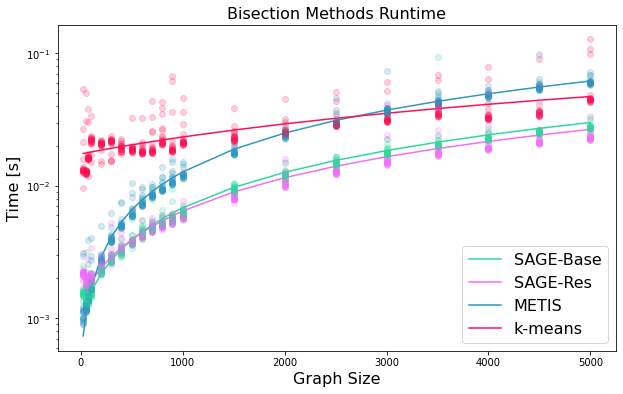

In [19]:
plt.figure(figsize=(10,6))
plt.semilogy(size,size*m1+b1,'-',color='#2CDA9D')
plt.semilogy(size,size*m2+b2,'-',color='#F26DF9')
plt.semilogy(size,size*m3+b3,'-',color='#2F97C1')
plt.semilogy(size,size*m4+b4,'-',color='#FF1053')

for i in range(ntests):
  plt.semilogy(size,gnn1_time[i,:],'o',color='#2CDA9D',alpha=.2)
  plt.semilogy(size,gnn2_time[i,:],'o',color='#F26DF9',alpha=.2)
  plt.semilogy(size,metis_time[i,:],'o',color='#2F97C1',alpha=.2)
  plt.semilogy(size,kmeans_time[i,:],'o',color='#FF1053',alpha=.2)


fs = 16

plt.legend(['SAGE-Base','SAGE-Res','METIS','k-means'],fontsize=fs)
plt.xlabel('Graph Size',fontsize=fs)
plt.ylabel('Time [s]',fontsize=fs)
plt.title('Bisection Methods Runtime',fontsize=fs)
plt.savefig('runtime.png',dpi=300)